In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np
import pandas as pd
import random
import scipy as sp
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import pytry

First, we just read the raw data file.  We drop any rows that have N/A data in them.

In [2]:
data = pd.read_csv("pinsoro-2017-06-20-145454904791-small.csv", low_memory=False)

x = np.array(data.iloc[:,11:195]).astype(float) #array of data for purple child (points in space for each frame)
labs = np.array(data.iloc[:,218]).astype(str) #array of labels (purple child annotations, engagement)
a = []
for i in range(x.shape[1]):
    y = pd.Series(x[:,i])
    z = y.interpolate(limit_direction='both')
    a.append(z)
a = pd.DataFrame(a)
a = a.dropna()
a = np.array(a).T

Here's a helper function to take a window of that data, extract it out, and resample it to a given dt using interpolation.

In [3]:
def extract_pattern(start, end, target_dt): #function to extract consecutive frames with the same label 
    pattern = np.array(a[start:end,:]).astype(float)
    frames = np.array(data.iloc[start:end,9]).astype(int)

    good_indices = frames != -1
    frames = frames[good_indices]
    pattern = pattern[good_indices]

    fps = 30.0
    t_sample = (frames - frames[0])/fps

    t = np.arange(int(t_sample[-1]/target_dt))*target_dt

    result = []
    for i in range(pattern.shape[1]):       
        p = np.interp(t, t_sample, pattern[:,i])
        result.append(p)
    result = np.array(result).T

    return t, result

Now we find the slices of data that correspond to different labelled events

In [4]:
start=[]
start.append(0)
end=[]
label = []
for i in range(1, (len(labs)-1)):
    if labs[i]!=labs[i-1]:
        start.append(i)
    if labs[i]!=labs[i+1]:
        end.append(i)
        label.append(labs[i])

And then extract all that data out.  Notice that we're extracting it out with a dt of 1/30s, since that's about what the data is stored at.  This means we're not generating huge datasets.

In [5]:
t_noplay=[]
p_noplay=[]
t_goal=[]
p_goal=[]
t_aim=[]
p_aim=[]

target_dt = 1.0/30

for i in range(1,(len(start)-1)):
    if label[i]==('noplay'):
        ti, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
        t_noplay.append(ti)
        p_noplay.append(pi)
    if label[i]==('goaloriented'):
        ti, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
        t_goal.append(ti)
        p_goal.append(pi)
    if label[i]==('aimless'):
        ti, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
        t_aim.append(ti)
        p_aim.append(pi)

Now we collect all that data together and define training and test sets.

In [6]:
seed = 1
random.seed(seed)


############ randomly split data 80/20 into training and testing sets ############ 
random.shuffle(p_goal)
goal_train = p_goal[:(int(len(p_goal)*0.8))] 
goal_test = p_goal[(int(len(p_goal)*0.8)):]

random.shuffle(p_noplay)
noplay_train = p_noplay[:(int(len(p_noplay)*0.8))]
noplay_test = p_noplay[(int(len(p_noplay)*0.8)):]

Do the PCA (just on the training data)

In [7]:
train_all = np.vstack(goal_train+noplay_train)
pca_model = PCA(n_components=2).fit(train_all)

goal_train_pca = np.vstack([pca_model.transform(p) for p in goal_train])
noplay_train_pca = np.vstack([pca_model.transform(p) for p in noplay_train])
goal_test_pca = np.vstack([pca_model.transform(p) for p in goal_test])
noplay_test_pca = np.vstack([pca_model.transform(p) for p in noplay_test])



For speed reasons, we can control how much of the training and testing data to use

In [8]:
T_train = 20   # number of seconds to train on for each class
T_test = 20    # number of seconds to test on for each class

Let's take a look at the training data

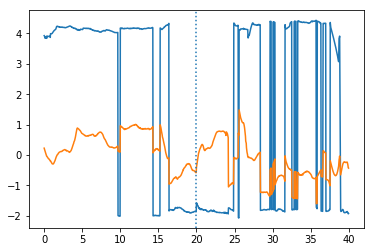

In [9]:
N_frames = int(T_train*30)
training = np.vstack([goal_train_pca[:N_frames], noplay_train_pca[:N_frames]])
assert len(training) == N_frames*2

N_frames = int(T_test*30)
testing = np.vstack([goal_test_pca[:N_frames], noplay_test_pca[:N_frames]])
assert len(testing) == N_frames*2

plt.plot(np.arange(len(training))/30.0,training)
plt.axvline(T_train, ls=':')


Feed the training data into the network and record what information would be fed into the pool.

In [10]:
D = 2

theta = 0.5
net = nengo.Network(seed=seed)
with net:
    process = nengo.processes.WhiteSignal(period=100., high=3.0, y0=0)
    rw = []
    for i in range(D):
        rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                  process=process, 
                                                  neuron_type=nengo.LIFRate()))
        
    
    node_pool = nengo.Node(None, size_in=rw[0].state.size_out*D)

    start = 0
    for r in rw:
        nengo.Connection(r.state, node_pool[start:start+r.state.size_out])
        start += r.state.size_out
        
        
    
    stim = nengo.Node(nengo.processes.PresentInput(training, presentation_time=1.0/30))
    assert stim.size_out == D
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)

    p_node_pool = nengo.Probe(node_pool)
        
        
sim = nengo.Simulator(net)
with sim:
    sim.run(T_train*2)        

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Now let's actually make that pool of neurons, and then compute its activity for the values that the rolling windows will feed into it.

In [11]:

pool_model = nengo.Network()
with pool_model:
    pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                          neuron_type=nengo.LIFRate(), seed=1)
pool_sim = nengo.Simulator(pool_model)
    
import nengo.utils.ensemble

_, a = nengo.utils.ensemble.tuning_curves(pool, pool_sim, inputs=sim.data[p_node_pool])

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

And let's compute a decoder

In [12]:
N = int(T_train*1000)
target = np.hstack([np.ones(N), -np.ones(N)]).reshape(-1, 1)
dec, info = nengo.solvers.LstsqL2(reg=0.1)(a, target)

How well does that decoder do?   We could compute rmse, but instead of that let's do classification accuracy.

Text(0.5,1,'training classification accuracy: 68.98%')

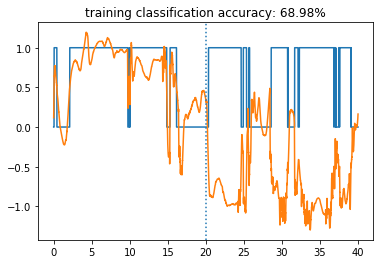

In [13]:
v = np.dot(a, dec)
classify1 = np.isclose(v[:N], 1, atol=0.5)
classify2 = np.isclose(v[N:], -1, atol=0.5)
classify = np.append(classify1, classify2)
score = np.mean(classify)

plt.plot(sim.trange(), classify)
plt.plot(sim.trange(), v)
plt.axvline(T_train, ls=':')
plt.title('training classification accuracy: %1.2f%%' % (score*100))

Now let's run it on the test set.  We combine the rolling window, the pool, and the decoder into one model.

In [14]:

D = 2

theta = 0.5
test_net = nengo.Network(seed=seed)
with test_net:
    process = nengo.processes.WhiteSignal(period=100., high=3.0, y0=0)
    rw = []
    for i in range(D):
        rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                  process=process, 
                                                  neuron_type=nengo.LIFRate()))
        
    
    pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                          neuron_type=nengo.LIFRate(), seed=1)

    start = 0
    for r in rw:
        nengo.Connection(r.state, pool[start:start+r.state.size_out])
        start += r.state.size_out
        
        
    
    stim = nengo.Node(nengo.processes.PresentInput(training, presentation_time=1.0/30))
    assert stim.size_out == D
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)

    p_stim = nengo.Probe(stim)
    
    result = nengo.Node(None, size_in=1)
    nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)
    
    p_result = nengo.Probe(result)
    
    
test_sim = nengo.Simulator(test_net)
test_sim.run(T_test*2)        

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Text(0.5,1,'testing classification accuracy: 63.36%')

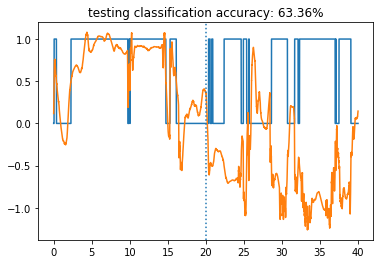

In [15]:
N = int(T_test*1000)

v = test_sim.data[p_result]
classify1 = np.isclose(v[:N], 1, atol=0.5)
classify2 = np.isclose(v[N:], -1, atol=0.5)
classify = np.append(classify1, classify2)
score = np.mean(classify)

plt.plot(sim.trange(), classify)
plt.plot(test_sim.trange(), v)
plt.axvline(T_test, ls=':')
plt.title('testing classification accuracy: %1.2f%%' % (score*100))




Now we test on the aimless patterns where the output should be around 0.

In [16]:
random.shuffle(p_aim)

aimless_patterns1 = {}
aimless_patterns2 = {}
i=0
for ap in p_aim:
    aimless_patterns1[i] = pca_model.transform(ap)[:,0]
    aimless_patterns2[i] = pca_model.transform(ap)[:,1]
    i+=1

N_frames = int(T_test*30)

test_aim1 = np.array(aimless_patterns1[0])
for ap in range(1,(len(aimless_patterns1))):
    test_aim1 = np.hstack([test_aim1,aimless_patterns1[ap]])
test_aim1 = test_aim1[:N_frames]

test_aim2 = np.array(aimless_patterns2[0])
for ap in range(1,(len(aimless_patterns2))):
    test_aim2 = np.hstack([test_aim2,aimless_patterns2[ap]])
test_aim2 = test_aim2[:N_frames]


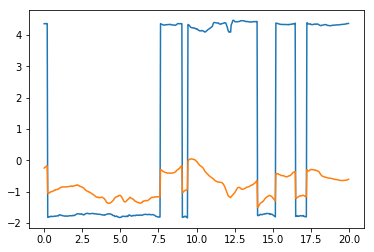

In [17]:
test_aim = np.vstack([test_aim1[:N_frames], test_aim2[:N_frames]]).T
assert len(test_aim) == N_frames


plt.plot(np.arange(len(test_aim))/30.0,test_aim)

In [18]:
D = 2

theta = 0.5
aim_test_net = nengo.Network(seed=seed)
with aim_test_net:
    process = nengo.processes.WhiteSignal(period=100., high=3.0, y0=0)
    rw = []
    for i in range(D):
        rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                  process=process, 
                                                  neuron_type=nengo.LIFRate()))
        
    
    pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                          neuron_type=nengo.LIFRate(), seed=1)

    start = 0
    for r in rw:
        nengo.Connection(r.state, pool[start:start+r.state.size_out])
        start += r.state.size_out
        
        
    
    stim = nengo.Node(nengo.processes.PresentInput(test_aim, presentation_time=1.0/30))
    assert stim.size_out == D
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)

    p_stim = nengo.Probe(stim)
    
    result = nengo.Node(None, size_in=1)
    nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)
    
    p_result = nengo.Probe(result)
    
    
aim_test_sim = nengo.Simulator(aim_test_net)
aim_test_sim.run(T_test)   

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Text(0.5,1,'testing classification accuracy: 27.07%')

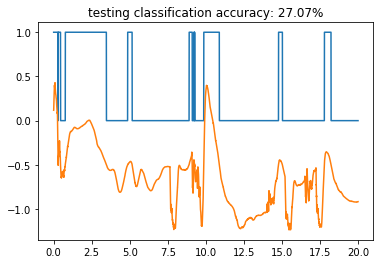

In [19]:
N = int(T_test*1000)

v = aim_test_sim.data[p_result]
classify = np.isclose(v, 0, atol=0.5)
classify[N:] = 1-classify[N:]
score = np.mean(classify)

plt.plot(aim_test_sim.trange(), classify)
plt.plot(aim_test_sim.trange(), v)
plt.title('testing classification accuracy: %1.2f%%' % (score*100))